<a href="https://colab.research.google.com/github/venk-meg/STRIKE/blob/main/1D_CNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Clone and move into repo
!git clone https://github.com/venk-meg/STRIKE.git
%cd STRIKE


Cloning into 'STRIKE'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 395 (delta 24), reused 0 (delta 0), pack-reused 277 (from 2)
Receiving objects: 100% (395/395), 2.81 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (156/156), done.
/content/STRIKE/STRIKE


# Data Prep

In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load data
data_path = "data_ml/"
gestures = os.listdir(data_path)

X = []
y = []

# Load and format each gesture sample
for gesture in gestures:
    gesture_path = os.path.join(data_path, gesture)
    if not os.path.isdir(gesture_path):
        continue

    for file in os.listdir(gesture_path):
        if file.endswith(".csv") and not file.startswith("trial_"):
            df = pd.read_csv(os.path.join(gesture_path, file))

            # Drop timestamp
            if 'timestamp' in df.columns:
                df = df.drop(columns=['timestamp'])

            data = df.to_numpy()

            # Sample length check --> as CNNs require all samples to be the same length. Truncate or pad if lengths are not the same.
            # HARDCODED 217 for now
            if data.shape[0] < 217:
              padding = np.zeros((217 - data.shape[0], data.shape[1]))
              data = np.vstack([data, padding])

            elif data.shape[0] > 217:
              data = data[:217, :]  # Truncate


            X.append(data)
            y.append(gesture)

# Convert to arrays
X = np.array(X)  # (samples, timesteps, channels)
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.3, stratify=y_encoded, random_state=42
)

print("X shape:", X_train.shape)
print("y shape (one-hot):", y_train.shape)
print("Classes:", label_encoder.classes_)


X shape: (91, 217, 19)
y shape (one-hot): (91, 7)
Classes: ['deleterecording' 'listen' 'makefist' 'nextrecording' 'releasefist'
 'selectend' 'slice']


# Build and train CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling1D(2),
    BatchNormalization(),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')  # softmax for multi-class
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=8,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5389 - loss: 1.8642 - val_accuracy: 0.7000 - val_loss: 2.2555
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8943 - loss: 0.6142 - val_accuracy: 0.8000 - val_loss: 1.2731
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8907 - loss: 0.5067 - val_accuracy: 0.8750 - val_loss: 0.8897
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9539 - loss: 0.3534 - val_accuracy: 0.8500 - val_loss: 0.7153
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9310 - loss: 0.3795 - val_accuracy: 0.9500 - val_loss: 0.5368
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9800 - loss: 0.1269 - val_accuracy: 0.9750 - val_loss: 0.1902
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9521 - loss: 0.1654 - val_accuracy: 0.9750 - val_loss: 0.3757
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9954 - loss: 0.0064 - val_accuracy: 0.8250 - val_loss: 0.

# Evaluate

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

📄 Classification Report:
                 precision    recall  f1-score   support

deleterecording       1.00      1.00      1.00         4
         listen       1.00      0.83      0.91         6
       makefist       1.00      1.00      1.00         6
  nextrecording       0.86      1.00      0.92         6
    releasefist       1.00      1.00      1.00         6
      selectend       1.00      1.00      1.00         6
          slice       1.00      1.00      1.00         6

       accuracy                           0.97        40
      macro avg       0.98      0.98      0.98        40
   weighted avg       0.98      0.97      0.97        40



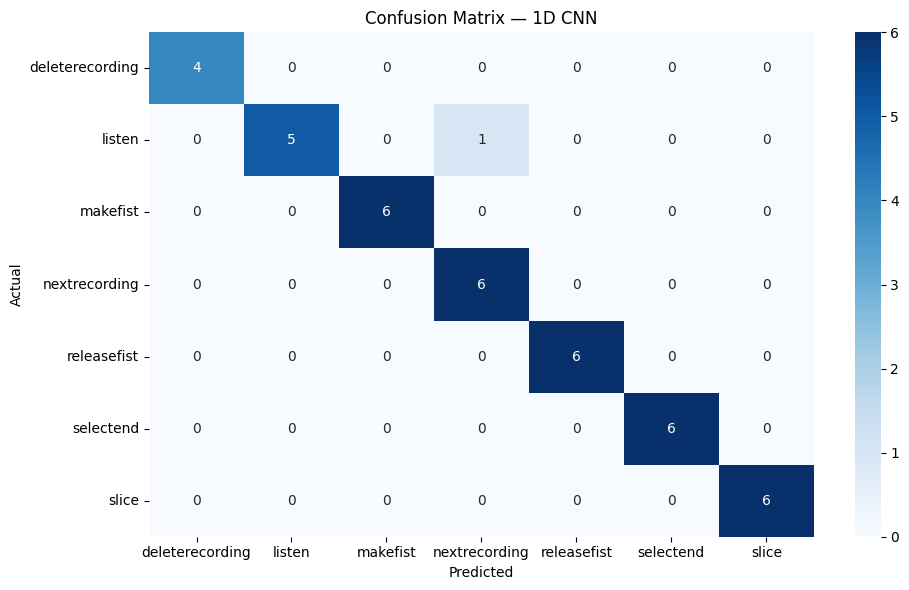

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Report
print("\n📄 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — 1D CNN")
plt.tight_layout()
plt.show()


## Saving trained model as a tensorflow lite model

In [11]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimize for size (8-bit quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# You can optionally specify representative data if needed
# but for most use cases on microcontrollers, DEFAULT works

tflite_model = converter.convert()

# Save the TFLite model to file
tflite_model_path = "gesture_model_quantized.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"\n✅ Saved TensorFlow Lite model to: {tflite_model_path}")


Saved artifact at '/tmp/tmpdf4fkf5z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 217, 19), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140498844718992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844724560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844724944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844724176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844717072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844724752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844726480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844727056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844727248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844726096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140498844720912

## Convert .tflite to C array (for Arduino)

In [12]:
with open("gesture_model_quantized.tflite", "rb") as f:
    data = f.read()

hex_array = ', '.join(f'0x{b:02x}' for b in data)
with open("gesture_model.cc", "w") as f:
    f.write("const unsigned char gesture_model_tflite[] = {\n" + hex_array + "\n};\n")
    f.write(f"unsigned int gesture_model_tflite_len = {len(data)};")
